In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from subprocess import check_output
print(check_output(["ls", "../brazil_coin/input"]).decode("utf8"))

classification_dataset.tar.gz
classification_dataset.tar.gz.zip
regression_dataset.tar.gz
regression_dataset.tar.gz.zip
regression_sample



In [2]:
import os, sys
from IPython.display import display
from IPython.display import Image as _Imgdis
from PIL import Image
import numpy as np
from time import time
from time import sleep

Working with 968 images
Image examples: 
100_1477281750.jpg


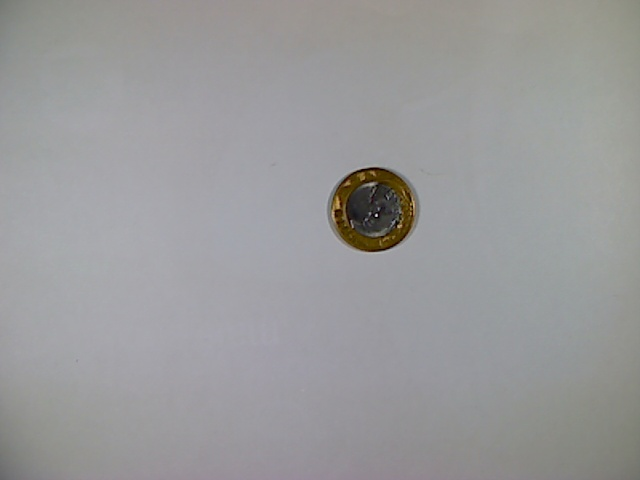

100_1477281756.jpg


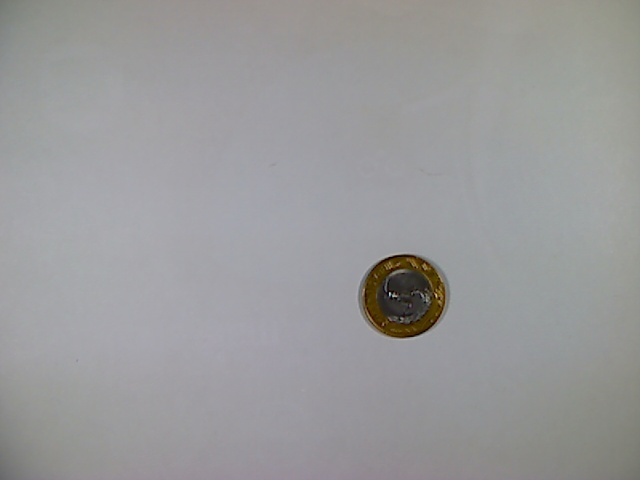

In [3]:
folder = "../brazil_coin/input/regression_sample"

onlyfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

print("Working with {0} images".format(len(onlyfiles)))
print("Image examples: ")

for i in range(40, 42):
    print(onlyfiles[i])
    display(_Imgdis(filename=folder + "/" + onlyfiles[i], width=240, height=320))

opencv를 설치해서 동전 이미지를 잘라와야 한다. 

http://wandlab.blogspot.kr/2016/11/python3-opencv3-anaconda3.html

python3라서 설치할때는 opencv3로 설치해야 하는 듯

In [4]:
import cv2
import os
import shutil
import random
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf

%matplotlib inline

In [5]:
import tarfile

image_list = []
label_list = []

tar = tarfile.open('../brazil_coin/input/classification_dataset.tar.gz', "r:gz")
for tarinfo in tar:
    tar.extract(tarinfo.name)
    if(tarinfo.name[-4:] == '.jpg'):
        image_list.append(np.array(cv2.imread(tarinfo.name, cv2.IMREAD_COLOR)))
        label_list.append(tarinfo.name.split('_')[0])
    if(tarinfo.isdir()):
        os.rmdir(tarinfo.name)
    else:
        os.remove(tarinfo.name)    
   
tar.close()

images = np.array(image_list)
labels = np.array(label_list)

coins 만 추출해내는 함수 정의

In [7]:
def extract_coins(img, to_size=100):
    """
    Find coins on the image and return array
    with all coins in (to_size, to_size) frame 
    
    return (n, to_size, to_size, 3) array
           array of radiuses fo coins
    n - number of coins
    color map: BGR
    """
    # Convert to b&w
    cimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Find circles on the image
    circles = cv2.HoughCircles(
        cimg, cv2.HOUGH_GRADIENT, 2, 60, param1=300, param2=30, minRadius=30, maxRadius=50)
    
    # Convert to HSV colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Define color range for masking
    lower = np.array([0,0,0])
    upper = np.array([255,255,90])
    # Apply the mask
    mask = cv2.blur(cv2.inRange(hsv, lower, upper), (8, 8))
    
    frames = []
    radiuses = []
    # If circles were not found
    if circles is None:
        return None, None
    
    for circle in circles[0]:
        
        center_x = int(circle[0])
        center_y = int(circle[1])
        
        # If center of coin lays in masked coin range
        if not mask[center_y, center_x]:
            continue
        
        # increase radius by C
        # circle detector tends to decrease radius
        radius = circle[2] + 3
        
        radiuses.append(radius)
        
        # Coordinates of upper left corner of square
        x = int(center_x - radius)
        y = int(center_y - radius)
        
        # As radius was increased the coordinates
        # could go out of bounds
        if y < 0:
            y = 0
        if x < 0:
            x = 0
        
        # Scale coins to the same size
        resized = cv2.resize(img[y: int(y + 2 * radius), x: int(x + 2 * radius)], 
                             (to_size, to_size), 
                             interpolation = cv2.INTER_CUBIC)

        frames.append(resized)

    return np.array(frames), radiuses

코인 추출하기

In [8]:
# The coins images are extracted from original images using extract_coins function
scaled = []
scaled_labels = []
for nominal, image in zip(labels, images):
    #print(image)
    prepared, _ = extract_coins(image)
    if prepared is not None and len(prepared):
        scaled.append(prepared[0])
        scaled_labels.append(nominal)

Convert string labels to categorical for use in model training

기존에는 keras로 되어있었던 one hot encoding 을 텐서플로우 방식으로 바꿈

In [19]:
# Convert the string labels to int
print(np.array(scaled_labels).shape)
print(set(scaled_labels))
label_classes = set(scaled_labels)

labels_dict = {}
for v_i, v in enumerate(label_classes):
    labels_dict[v] = v_i
        
print(labels_dict)

labels = []
for label in scaled_labels:
    labels.append(labels_dict[label])
    
print(set(labels))    

y_binary = tf.one_hot(labels,depth=5)

print(y_binary)

(3035,)
{'all/10', 'all/25', 'all/100', 'all/50', 'all/5'}
{'all/10': 0, 'all/50': 3, 'all/25': 1, 'all/100': 2, 'all/5': 4}
{0, 1, 2, 3, 4}
Tensor("one_hot_3:0", shape=(3035, 5), dtype=float32)


In [10]:
np.shape(scaled_labels)

(3035,)

In [11]:
np.shape(scaled)

(3035, 100, 100, 3)

In [26]:
with tf.Session() as sess:
    print(sess.run(y_binary))

[[ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 ..., 
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]]


show image samples

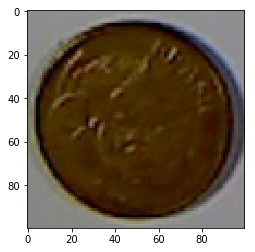

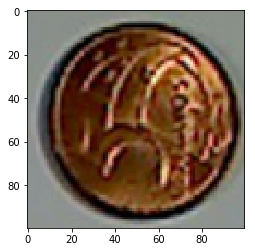

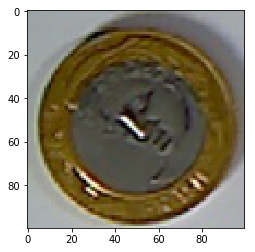

In [32]:
# Plot sample images from list
for image_item in random.sample(scaled, 3): 
    image = np.array(image_item)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

modeling